# From Taxis to Investment Bank Revenues in Manhattan

Our team decided to explore the relationship between New York taxi data and investment banking revenues. Teddy, having worked in investment banking for the past few summers noticed that the job was quite human-capital intensive particularly at the junior level. He noticed that the more deals a firm was working on the more hours the junior employees worked. He then wondered if the hours junior employees worked could be observed via publicly available New York taxi data. Because junior investment bankers rarely leave the office before 9pm, while other departments leave earlier on average, it seems plausible that there will be relatively less noise in the data than other time periods. While firms in busier areas like Times Square may have substantial noise in the data, firms in lower Manhattan will likely have far less noise during late hours given the smaller population and decreased nightlife activity. As such, we look to see if by observing late-night taxi pickups around these firms we could deduce the general working hours of investment banking junior employees. Our hypothesis is that observing how late these employees are working will help us approximate the volume of deal flow these firms are working on, and thus estimate the firm’s yet to be announced investment banking revenue.

To explore this question, we utilized New York taxi data publicly available through the New York Taxi and Limousine Commission, firm geographical coordinate data from Google Maps and firm financial data from Bloomberg. After pulling the data and analysing it via running linear regressions of quarterly lateness on investment banking revenue, we notice that for some firms there exists a statistically significant positive correlation.

# Methodology

   After devising our initial idea, we set out to find the data necessary to bring our concept to fruition. The smoothest part of our data collection was selecting our firms and recording the GPS coordinates of their “ride area”, the area in which someone leaving the firm would likely hail a cab. At first we thought since we were recoding latitudes and longitudes we would just record the points of a square and select rides that were within those squares. However, we quickly realized that the streets of New York City do not line up with latitude and longitude squares; set at a diagonal, we had to record eight data points to create a parallelogram for each firm.
   
 While we initially wanted to consider both Uber ride data and New York City yellow cab ride date, the limited availability of the Uber data constricted us right off the bat. This was our first challenge, but after glancing at the taxi data, we realized it was more than enough data to process. In fact, each month of data was almost 2.5 gigabytes in size, verging on containing 1.5 million rows of data for each month. While this much data seems very fruitful for possible analysis, the fact that our financial data was only recorded quarterly meant that as much taxi data as possible needed to be gathered to have any meaningful analysis. Basically, to create a data point for the regressions we planned to run, we needed three months of taxi data to be condensed into one data point, to be paired with the single data point of total revenue for each individual firm. We realized we needed to get as much data as possible, so a fast, easy way to clean the data (extracting only those cab rides that occurred near our investment banks) was essential.
 
We hoped that an API would help us to easily query the database to only retrieve the rides we wanted. Here we ran into our second problem: as far as we could figure out, the API was created by a third party and was no longer supported. Therefore, our only option left was to actually download each file and create a script to use our parallelograms to select the rides within each ride area. We did this in python creating an interactive script that accepted a source file as well as the month and year, and saved the file in a .csv file (with month and year automatically indicated in filename). Our python script is in the file taxi.py, and is run by calling the function extract_rides(year). We created the script to run on 2009 taxi data – only to find out that the header of the CSV was changed in following years. Therefore, we had to include the year as an argument to select which header to use while processing the CSV. The script writes out a new CSV file with values containing the ticker of the firm, the datetime of the ride, and the longitude and latitude.

Unfortunately, due to the size of each data file, the script took about 20 minutes to run. Collecting data was slow going, so we improvised by installing our script on as many lab computers as possible, using a crude form of parallel processing. It still took many hours to gather, but the task would have taken days or weeks if we had just used our personal machines.

With the data in hand, we tried to do some analysis in python – but quickly discovered that this would be a tedious process. We resolved to migrate our data to a PostgreSQL Database for easier analysis. This proved a job that required a lot of copying and pasting due to the vast number of CSVs we had, but in the end, we had a database of approximately 1 GB, containing all taxi and financial data from 2010 -2014.
        	
After attempting to get madlab running, we settled for using Sci Kit Learn and NumPy to run regressions and employ some machine learning to see if we could find a correlation between lateness of rides and revenue for each individual term. As a result of the scope of our testing, we created thousands of visualizations of relationships between these two datasets. One interesting aspect of experimentation during this step was trying to figure out the ideal lag between number of late rides and the revenue. For example, if there were many late rides in Q1, would the revenue increase that we expected show up that quarter or be delayed, perhaps showing up later in the year? Because of this, we had to pair each quarter of data with four quarters of financial data, resulting in more regressions and visualizations than expected. 
	
Though our initial objective was to link taxi ride data with financial revenues, we also wanted to explore our rides dataset, as it contained interesting data. Connecting our PostgreSQL Database to Tableau, we were able to visualize thing in the ride data such as average departure time and even show the geographic location of our firms.


# Run It!

In [35]:
%matplotlib inline    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import taxi
from taxi import *
from IPython.display import Image, display

Run our script to filter rides from raw taxi data. It takes in a .csv file of the format given at this source: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

Note: running on even one month of data will take quite a while. There is a test_data file provided in the repo that will run much faster.  

We have also provided all of the processed data so that our full database can be recreated.

In [ ]:
#Interactive script, provide year and month (in this case test for both)
! ./filter_rides.sh
#This cannot be ran from python notebook as you have 
#to interact with terminal, should be run from terminal therefore

### Creating the database and running regressions / machine learning


Follow these steps, first run these. Note the database must be named "final_project":

In [39]:
#this gets rid of certain formatting characters that messed up our DB creation
! python -c 'import taxi; taxi.update_firm_financials()' > updated_financials.csv

In [ ]:
! createdb final_project

Now, copy folder "processesed_taxi_data" into project directory

Finally, run:

In [ ]:
! psql -f create.sql final_project
! psql -f create_regression_table.sql final_project


At this point, the database is completely populated!

# Results


In our exploration of the data, we sought to firstly find an answer to our original question about the usefulness of using taxi data to predict firms’ investment banking revenues. Secondly, we explored other aspects of our data to look for interesting findings and meaningful visualizations.

Primarily, we began to analyze our hypothesis by using linear regression on all the data. In using all our data for regression, we are not able to necessarily evaluate the predictive ability via machine learning, but we are able to explore the relationship between lateness and investment banking revenue and the strength of said relationship. To run our regressions and perform machine learning, we will use Scikit learn and Numpy. Also, we decided to run all regressions on our data excluding 2009, as we feel that the events of the financial crisis may skew our data in a way that is not representative of usual occurrences.

We run two sorts of regression on the data: standard Ordinary Least Squares and Logarithmic Ordinary Least Squares, where we take the natural log of the output, revenue and regress it against the natural log of the input, some metric of lateness. The intention of the Logarithmic regression is to allow for more useful interpretation of the coefficients as explained later. For each of these regression styles, we run a regression on each firm separately and for a number of metrics. These metrics include total quarterly lateness, average quarterly lateness and average daily lateness. Total quarterly lateness is simply the sum of lateness scores for each day in the quarter. Average quarterly lateness is the sum of the average daily lateness for each day in the quarter. Finally, average daily lateness is the average of the average daily lateness for each day in the quarter. 
Furthermore, for each regression, each firm and each metric, we run the regression applying one of 5 time lags. We do this, because it is possible that the work being done in any given quarter leads to revenues in the same quarter or a future quarter up to a year out. As such, we apply no lag or a lag of one quarter up to four quarters. All in, this means we run about 570 regressions on our data.

### Regular Regressions

Run the following script, and then the following cell to load an example visualization of our regressions (script takes about 5 minutes):

In [ ]:
! ./run_regressions.sh 

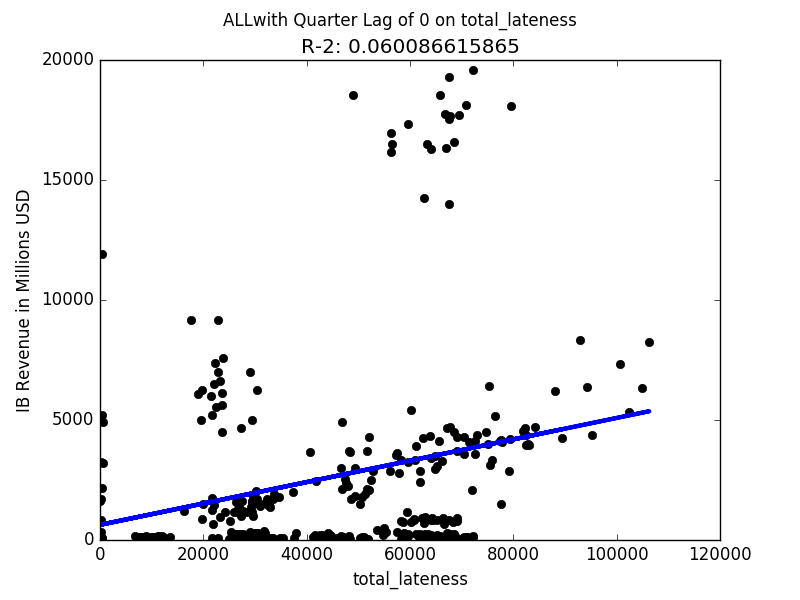

In [40]:
display(Image(filename='plots/PLOT_ALL_0_total_lateness.png'))

For our regular regressions, we notice that on all firms total lateness, with a lag of zero, we get a slightly positive correlation with an R-squared of 0.06 and a coefficient on lateness of 0.05. This suggests that about 6% of the variation in the data can be explained by our model, as opposed to simply guessing the mean. This also suggests that, on average an increase in quarterly lateness of one leads to an increase in investment banking revenue of $50,000, ceteris paribus. Similar, though less significant results are found for all forward lags up to four quarters. While this suggests a slight correlation, the regression will likely be much more telling on a firm-by-firm basis. 
	
We found some very interesting  and potentially substantial results for a few particular firms. Goldman Sachs (GS) had seemingly significant results on its total lateness regressions for all lags other than a lag of 4 quarters.

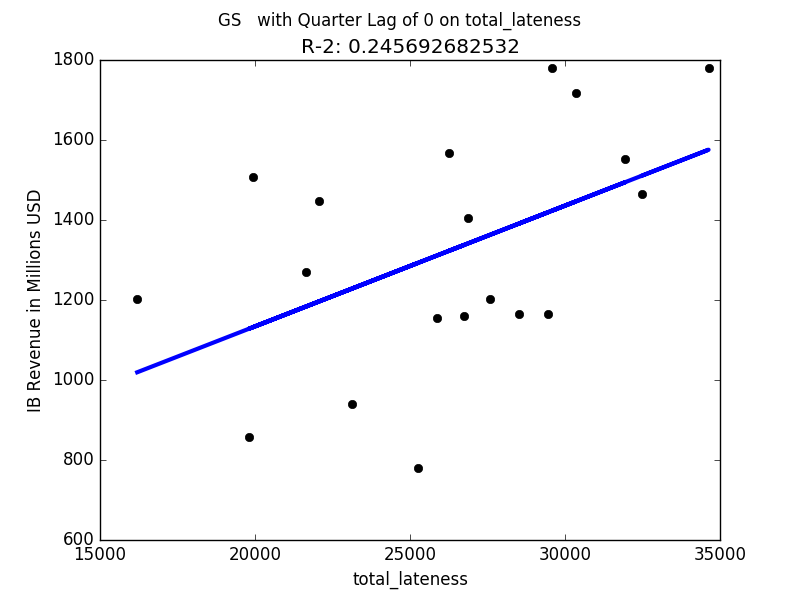

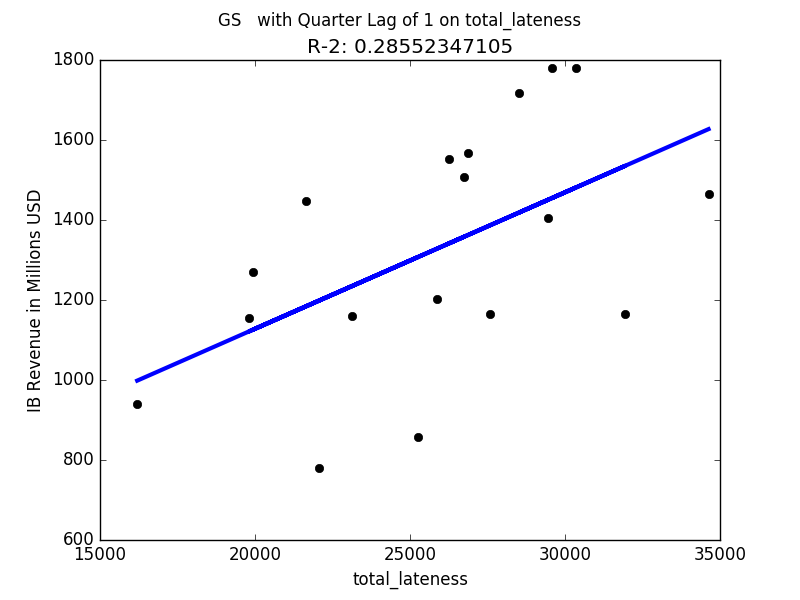

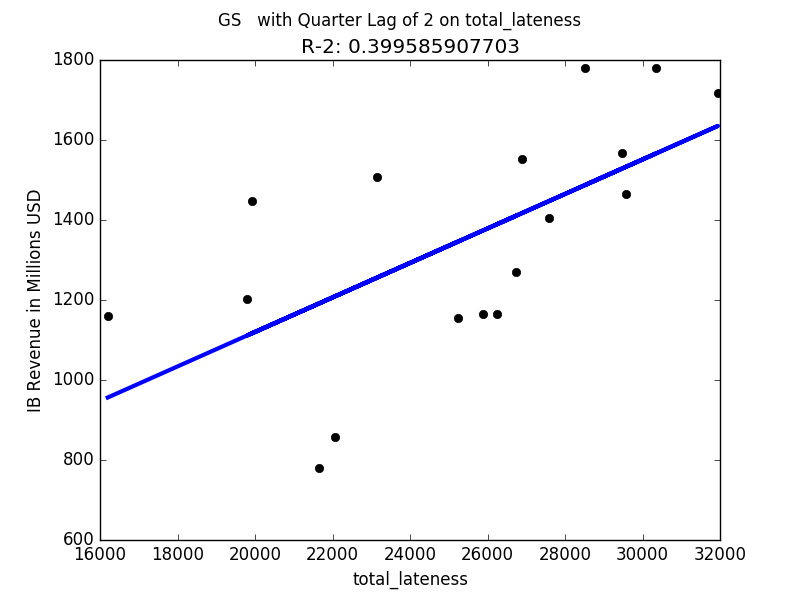

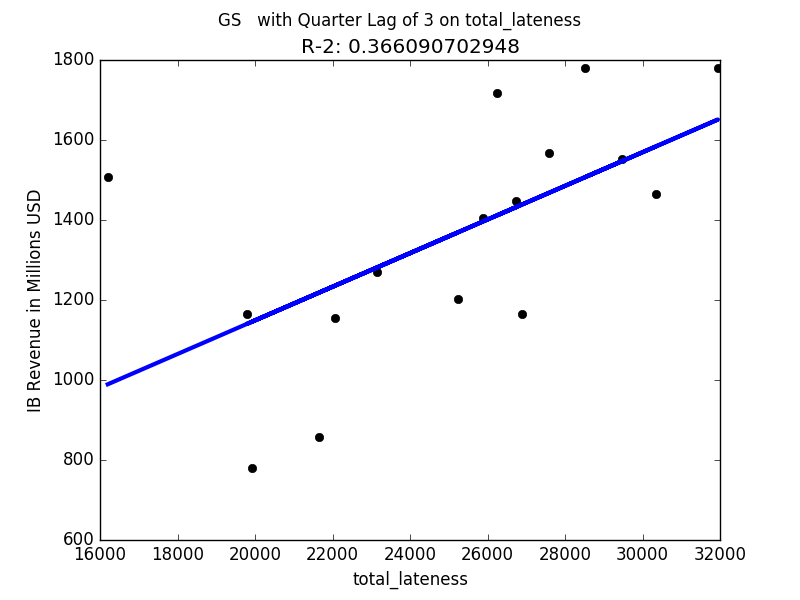

In [11]:
display(Image(filename='plots/PLOT_GS_0_total_lateness.png'))
display(Image(filename='plots/PLOT_GS_1_total_lateness.png'))
display(Image(filename='plots/PLOT_GS_2_total_lateness.png'))
display(Image(filename='plots/PLOT_GS_3_total_lateness.png'))

For a lag of zero, one, two and three quarters our model found  an R-squared of 0.25, 0.29, 0.40 and 0.37 respectively and coefficients on total lateness of 0.030, 0.034, 0.043 and 0.042 respectively. This suggests, for example, that with a quarter lag of 2, about 40% of the variation in the data can be explained by our regression model, and on average an increase in total lateness of 100 hours leads to an increase in investment banking revenue of $4.3 million, ceteris paribus.

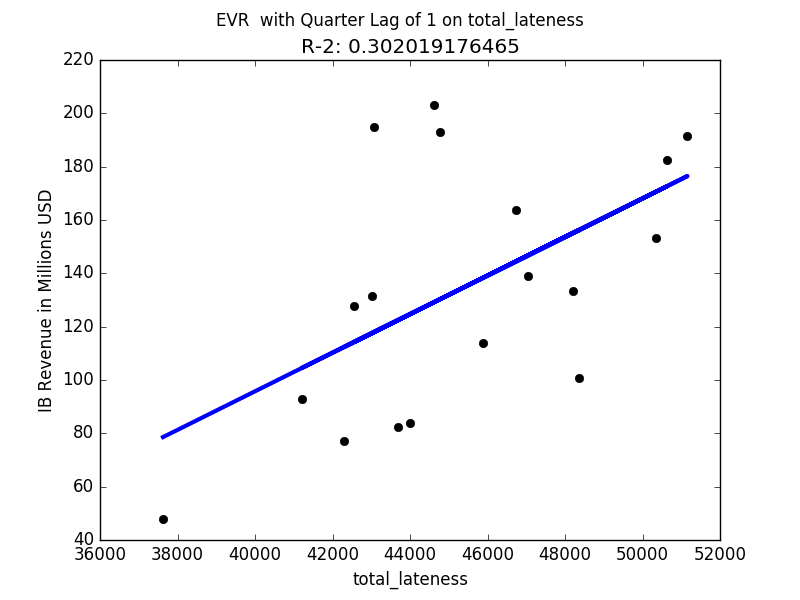

In [12]:
display(Image(filename='plots/PLOT_EVR_1_total_lateness.png'))

We also found some very interesting  results for Evercore (EVR). For a quarter lag of one our model found an R-squared of 0.30 and a coefficient on total lateness of 0.007. This suggests  that with a quarter lag of 1, about 30% of the variation in the data can be explained by our regression model, and on average an increase in total lateness of 100 hours leads to an increase in investment banking revenue of $700,000, ceteris paribus. 

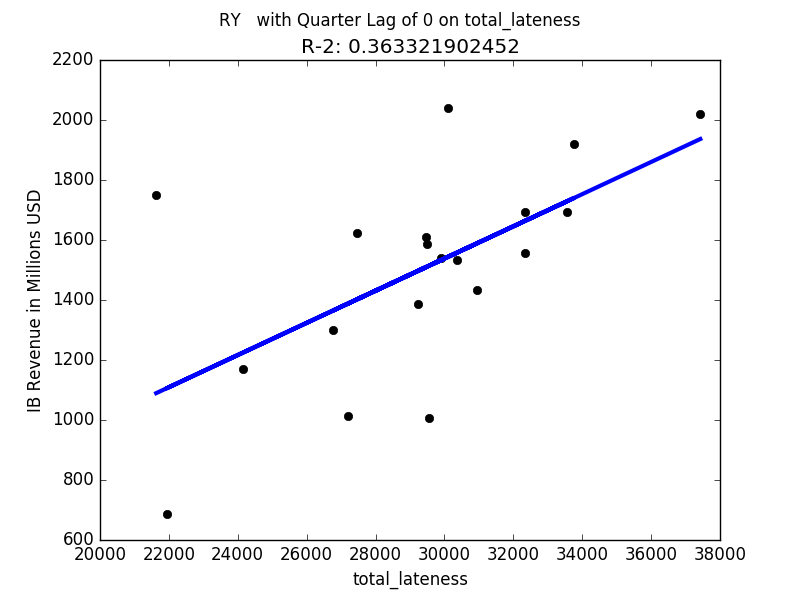

In [14]:
display(Image(filename='plots/PLOT_RY_0_total_lateness.png'))

Furthermore, for RBC (RY) with a quarter lag of zero on total lateness our model found an R-squared of 0.36 and a coefficient on total lateness of 0.054. This suggests that about 36% of the variation in the data can be explained by our regression model, and on average an increase in total lateness of 100 hours leads to an increase in investment banking revenue of $5.4 Million, ceteris paribus. 

From our results, we see that there are some regressions that appear to be somewhat significant, and usually with a lag of zero or one quarter. Also, total lateness seems to be the metric that is generally most revealing. For each of these regression, visualization is very important. Some of our results derived from our numerical results can be a bit misleading on their own.


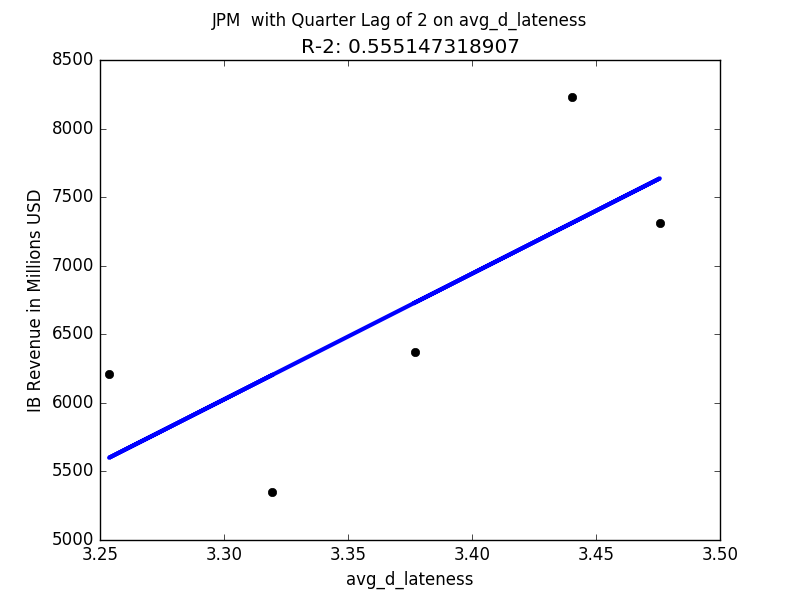

In [15]:
display(Image(filename='plots/PLOT_JPM_2_avg_d_lateness.png'))

The regression with the largest positive coefficient is JP Morgan (JPM) with a 2-quarter lag on average daily lateness. This regression has an R-squared of 0.56 and a coefficient on lateness of 9,172. This suggests that about 56% of the variation in the data can be explained by our regression model. This also suggests that, on average an increase in average daily lateness of one leads to an increase in investment banking revenue of $9.172 billion, ceteris paribus. While interesting this is somewhat misleading for a few reasons, Firstly, there are only five data points making the statistical significance of this questionable. Secondly, the regression run on total lateness with a 2-quarter lag is almost flat. This is likely because JP Morgan has the most employees of any of the firms. Asu such, a one-hour increase in average daily lateness leads to a far higher absolute increase than any other firm. So seeing such a significant rise in revenue and thus such a high coefficient is not surprising and is somewhat misleading. A logarithmic interpretation should be more revealing.

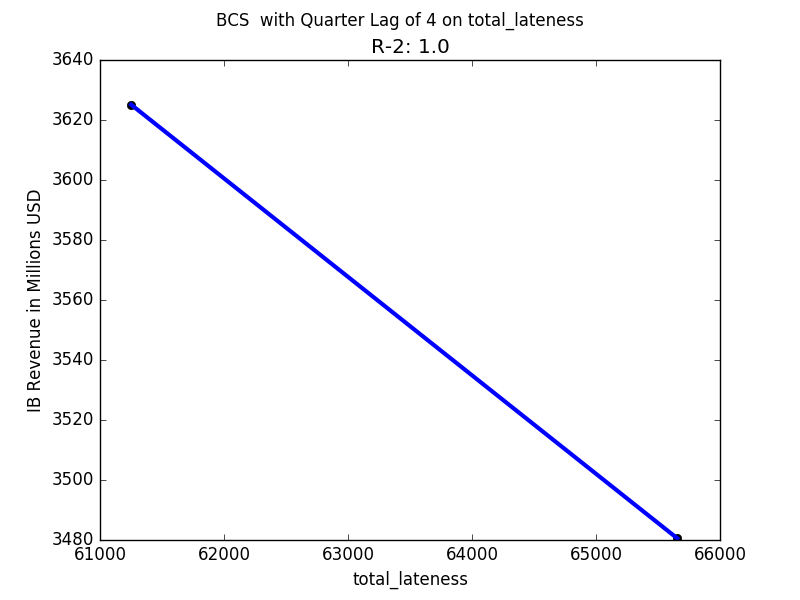

In [16]:
display(Image(filename='plots/PLOT_BCS_4_total_lateness.png'))

Furthermore, the regression with the highest R-squared is somewhat misleading without visualization. For Barclays (BCS), with a lag of 4 quarters on total lateness, we get an R-squared of 1. This suggests that about 100% of the variation in the data can be explained by our regression model. Without any more information, this would suggest a perfectly predictive model. When viewing the plot, we see that this is because it only has two data points, since Barclays did not publish financial data until later than our other firms. The results of this regression are essentially meaningless without more data.

### Logarithmic Regressions

First, in order to run the log regressions, run the following script:

In [ ]:
! ./run_log_regressions.sh

While the standard regressions are interesting, the logarithmic regressions can allow for a different interpretation of the coefficients. The way that the regression results are interpreted is an increase in lateness of 1%, leads to a (coefficient) percent increase in investment banking revenue.

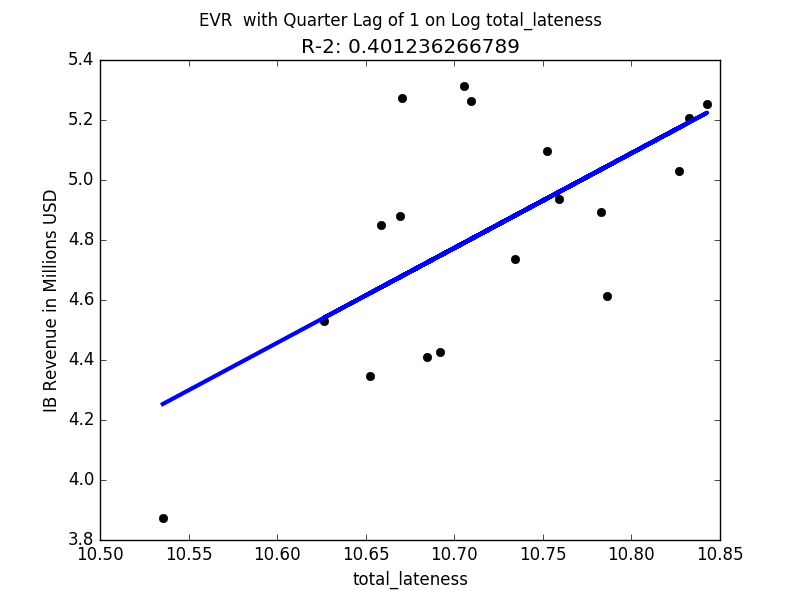

In [17]:
display(Image(filename='plots/LOG_PLOT_EVR_1_total_lateness.png'))

One regression that retains a lot of its significance is Evercore (EVR) with a quarter lag of 1 on total lateness.  Our model found an R-squared of 0.40 and a coefficient on total lateness of 3.16. This suggests  that with a quarter lag of 1, about 40% of the variation in the data can be explained by our regression model, and on average an increase in total lateness by 1% leads to 3.16% increase in investment banking revenue, ceteris paribus. While previous regression coefficients were heavily impacted by the size of the firms, this logarithmic regression eliminates those differences.

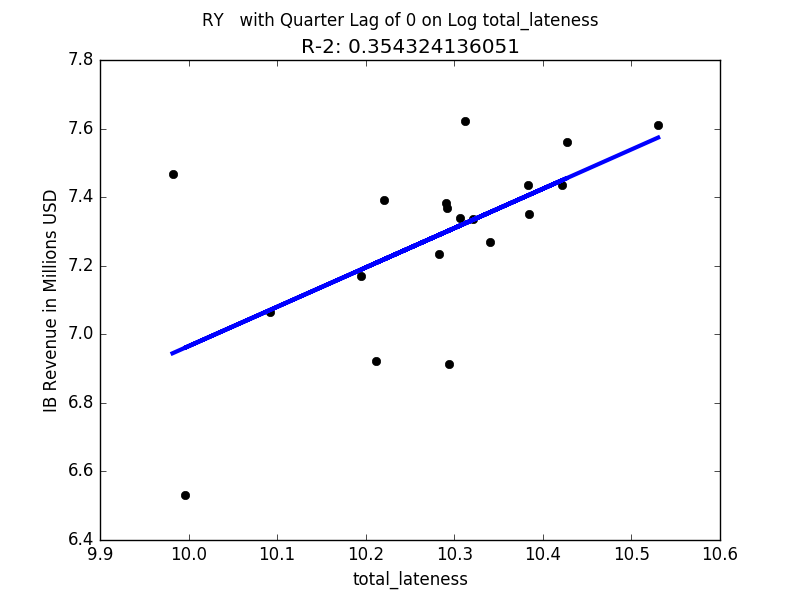

In [18]:
display(Image(filename='plots/LOG_PLOT_RY_0_total_lateness.png'))

Another that stands out still when using logarithms is RBC (RY) with a quarter lag of zero on total lateness our model found an R-squared of 0.35 and a coefficient on total lateness of 1.14. This suggests that about 35% of the variation in the data can be explained by our regression model as opposed to 36%, and on average an increase in total lateness of 1% leads to an increase in investment banking revenue of 1.14%, ceteris paribus.

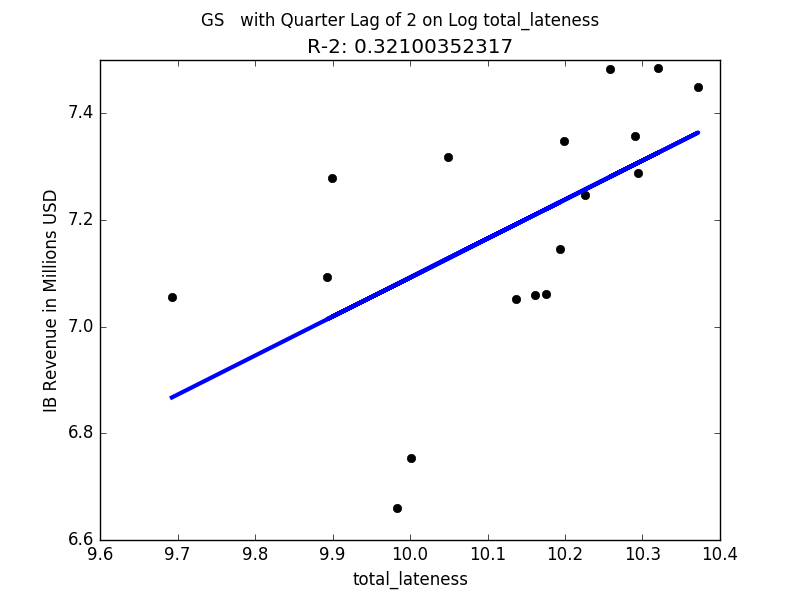

In [19]:
display(Image(filename='plots/LOG_PLOT_GS_2_total_lateness.png'))

When observing some of the previous regression now using logarithm, the interpretation of the results changes a bit, and thus some results seem less significant now. For example, Goldman Sachs (GS) with a lag of two quarters on total lateness produces  an R-squared of  0.32 and a coefficient on total lateness of 0.731. This suggests that about 32% of the variation in the data can be explained by our regression model as opposed to 40%, and on average an increase of 1% in total lateness leads to an increase in investment banking revenue of 0.7%, ceteris paribus.

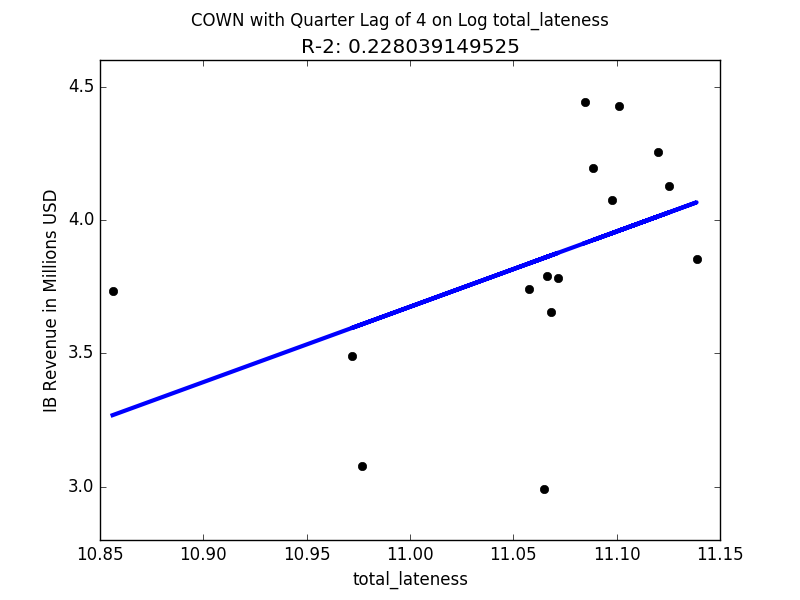

In [20]:
display(Image(filename='plots/LOG_PLOT_COWN_4_total_lateness.png'))

Some regressions stand out more significantly when using logarithms. Cowen (COWN), for example, with a lag of 4 quarters on total lateness produces an R-squared of  0.23 and a coefficient on total lateness of 2.82. This suggests that about 23% of the variation in the data can be explained by our regression model, and on average an increase of 1% in total lateness leads to an increase in investment banking revenue of 2.82%, ceteris paribus. In the standard regression, Cowen had a coefficient of  0.002, suggesting a small increase in revenue for a large increase in hours, but when we eliminate the absolute differences, Cowen’s revenue increases substantially, relative to its usual revenue with only a slight increase in relative late hours.

Overall, our findings suggest that there is some significant correlation for some firms between lateness and investment banking revenues. Our logarithmic regressions show some firms than are particularly efficient when it comes to the percentage increase in revenue vs. in lateness.

### Machine Learning

Run this script for machine learning, with an argument that splits data into training and test sets (use 50%):

In [22]:
! ./run_ml_regressions.sh 50


Running ML Regression on All Firms... 
Running ML Regression on BAC - No 2009... 
Running ML Regression on BCS - No 2009... 
Running ML Regression on BMO - No 2009... 
Running ML Regression on C - No 2009... 
Running ML Regression on COWN - No 2009... 
Running ML Regression on CS - No 2009... 
Running ML Regression on DB - No 2009... 
Running ML Regression on EVR - No 2009... 
Running ML Regression on GHL - No 2009... 
Running ML Regression on GS - No 2009... 
Running ML Regression on JPM - No 2009... 
Running ML Regression on LAZ - No 2009... 
Running ML Regression on MS - No 2009... 
Running ML Regression on NMR - No 2009... 
Running ML Regression on OPY - No 2009... 
Running ML Regression on RY - No 2009... 
Running ML Regression on SF - No 2009... 
Running ML Regression on UBS - No 2009... 
Done!



After running regressions on the entirety of the dataset, we employed machine learning, where we ran regressions on a portion of the data and then tested it on the rest of the data. These results were less impressive than those found by the full regressions, and by definition must be, because the fit could be only as good as full OLS regression at best. In our machine learning, we split the data in half for training and testing. The black points are training data and the red points are test data. The variance is noted at the top of the plots.

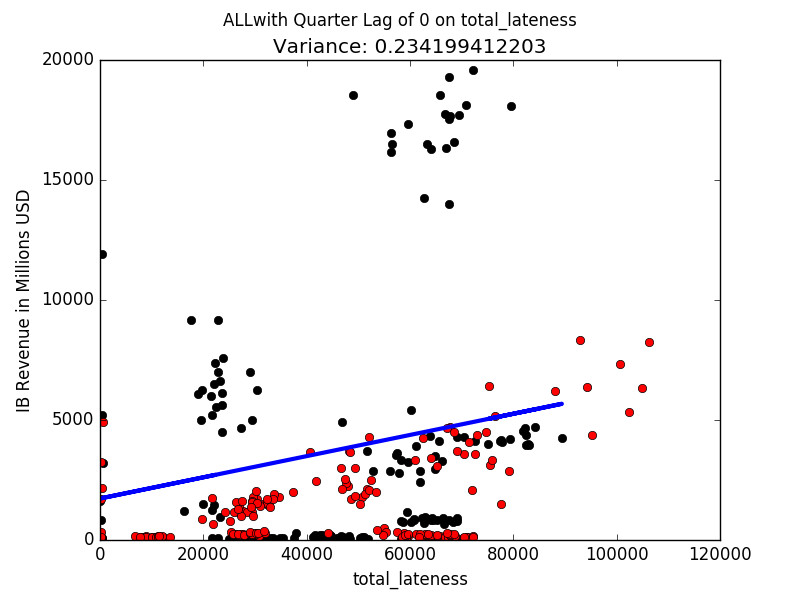

In [23]:
display(Image(filename='plots/ML_PLOT_ALL_0_total_lateness.png'))

When training and testing on All firms (ALL) with a lag of zero and total lateness, we get a variance of 0.23. This roughly suggests about a 23% accuracy of our model on the test data.

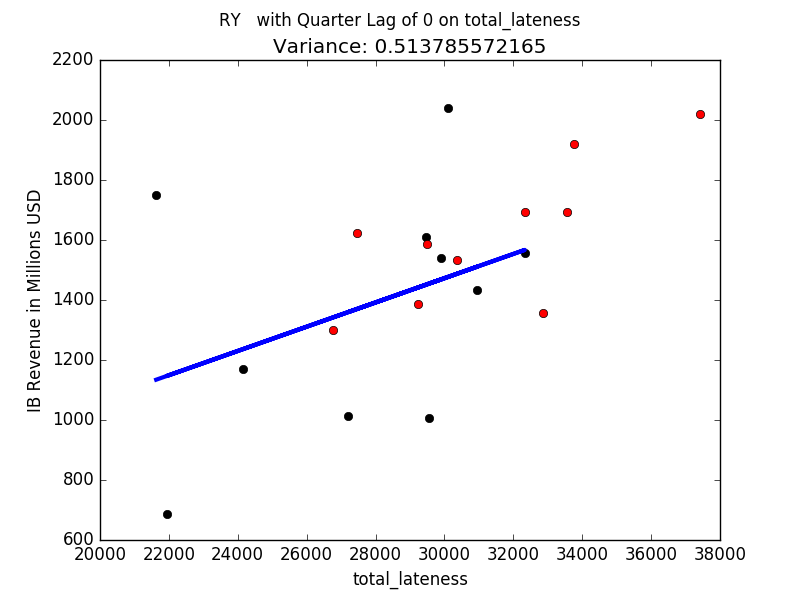

In [25]:
display(Image(filename='plots/ML_PLOT_RY_0_total_lateness.png'))

When training and testing on RBC (RY) with a lag of zero and total lateness, we get a variance of 0.51. This roughly suggests about a 51% accuracy of our model on the test data.

Overall, it seems that some of the previously impressive regression results were substantially reduced when breaking the data in half and testing on the other half. Perhaps a cross-validation method in the future would be impactful in this case.


## Further Visualizations:

We performed a number of visualizations using Tableau to explore the data from other angles. Some of these include average daily lateness per year, total lateness per year, and revenue per year. We noticed some interesting phenomena:

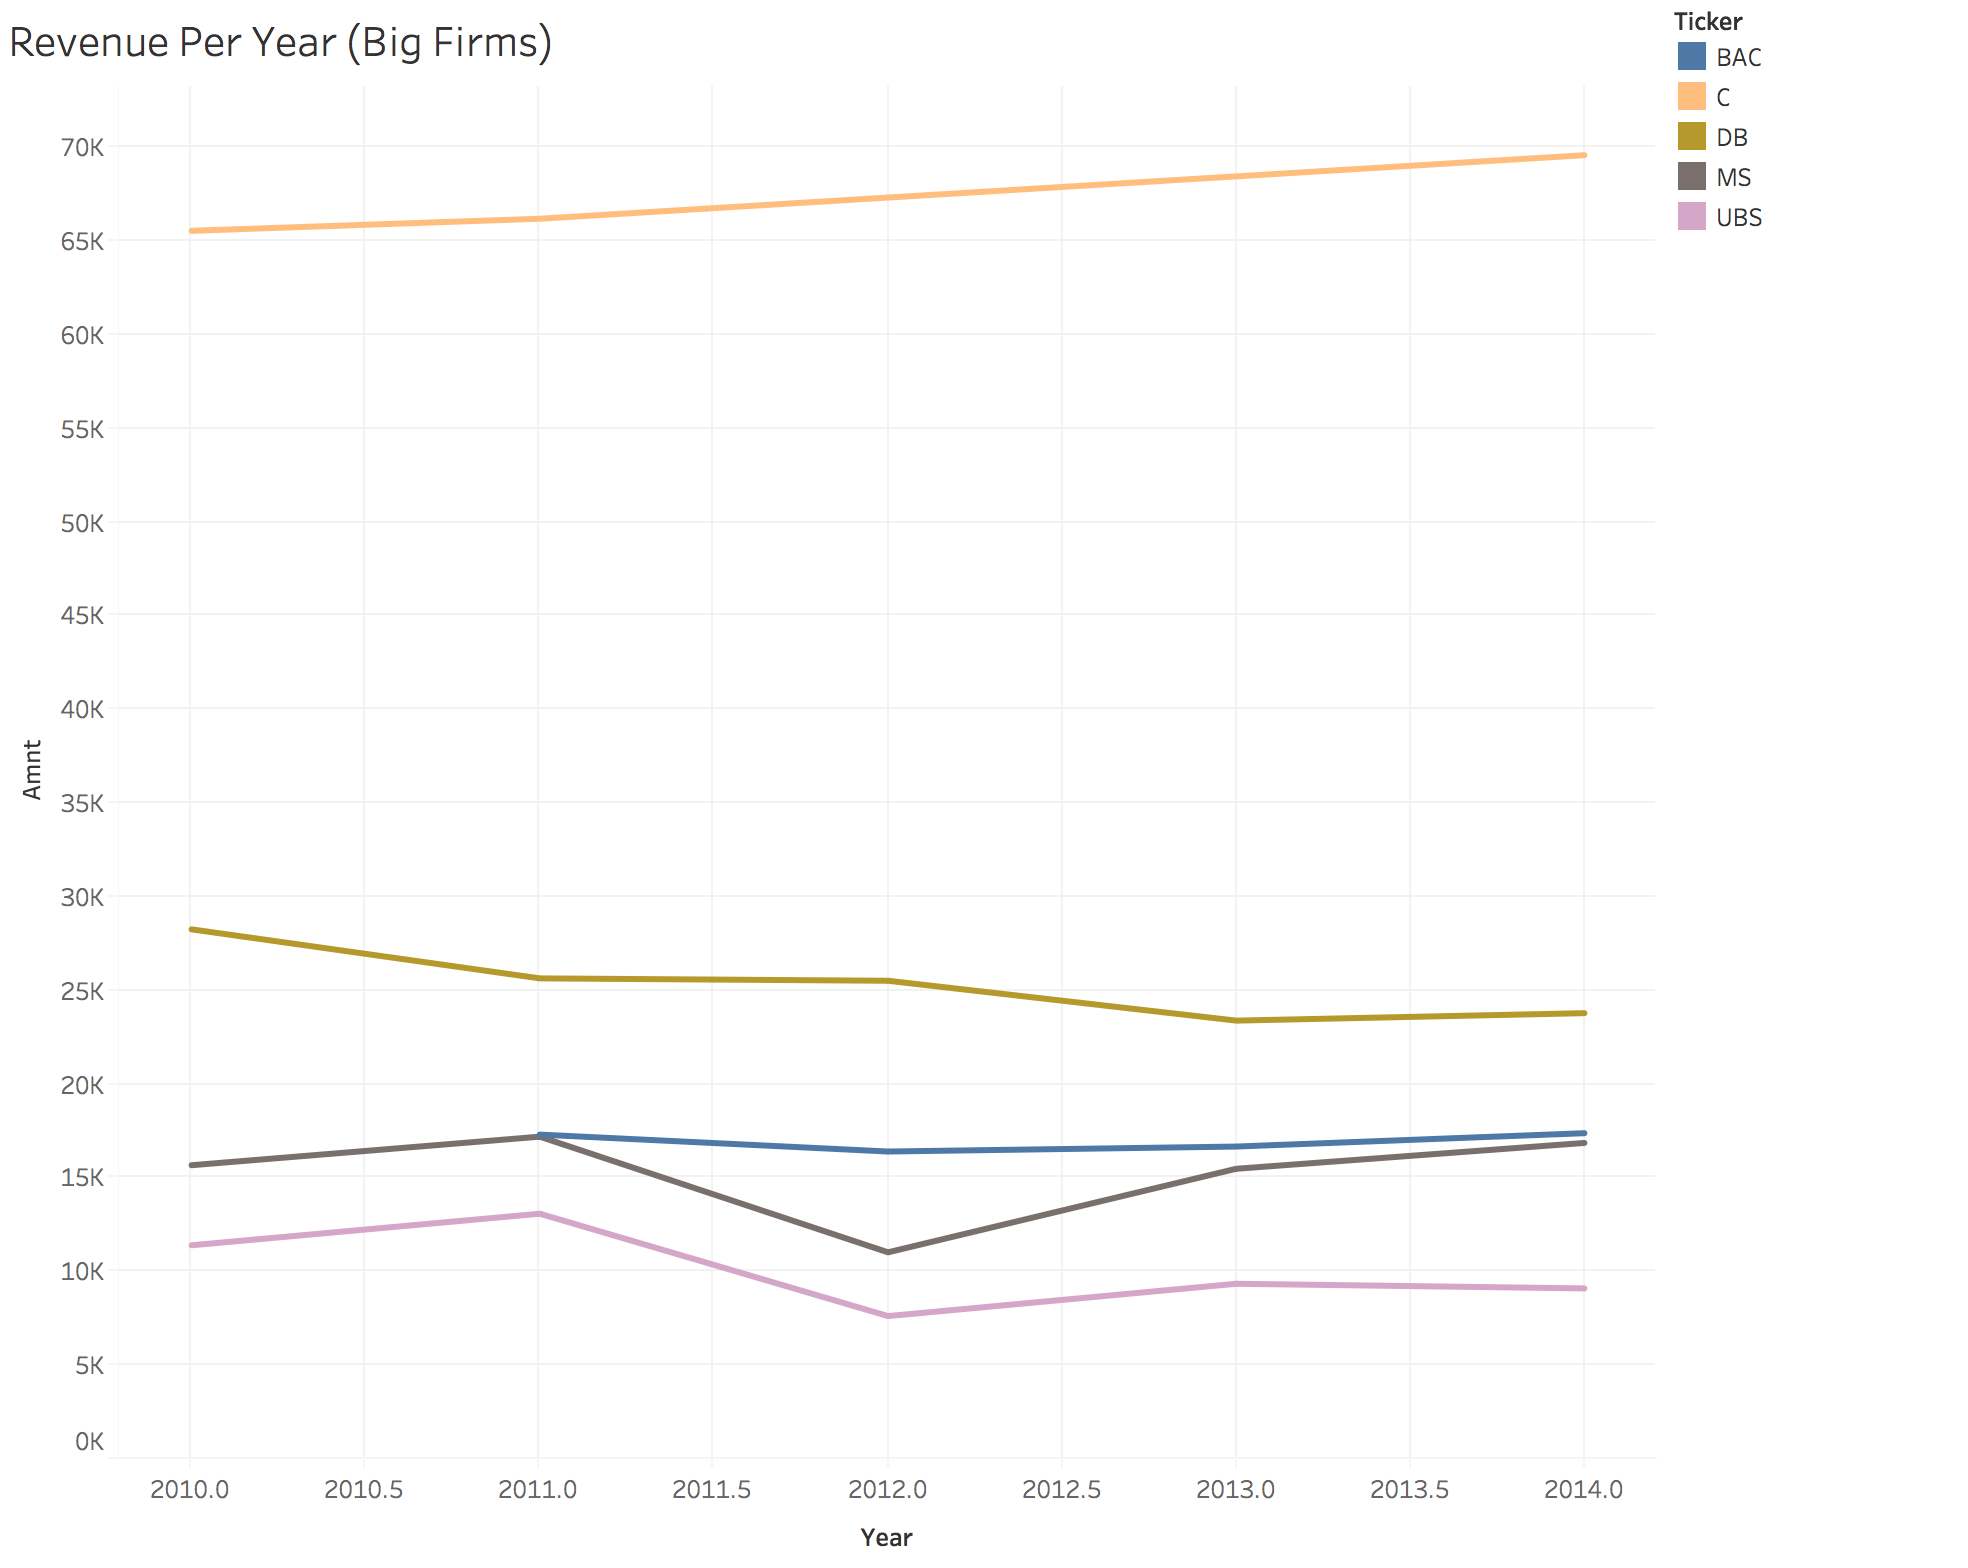

In [29]:
display(Image(filename='visualizations/revenue_per_year_big_firms.png'))

The first thing we noticed was that UBS had a large drop in revenue in the year 2011. We discovered that UBS went through a Rogue Trader Scandal resulting in large losses.

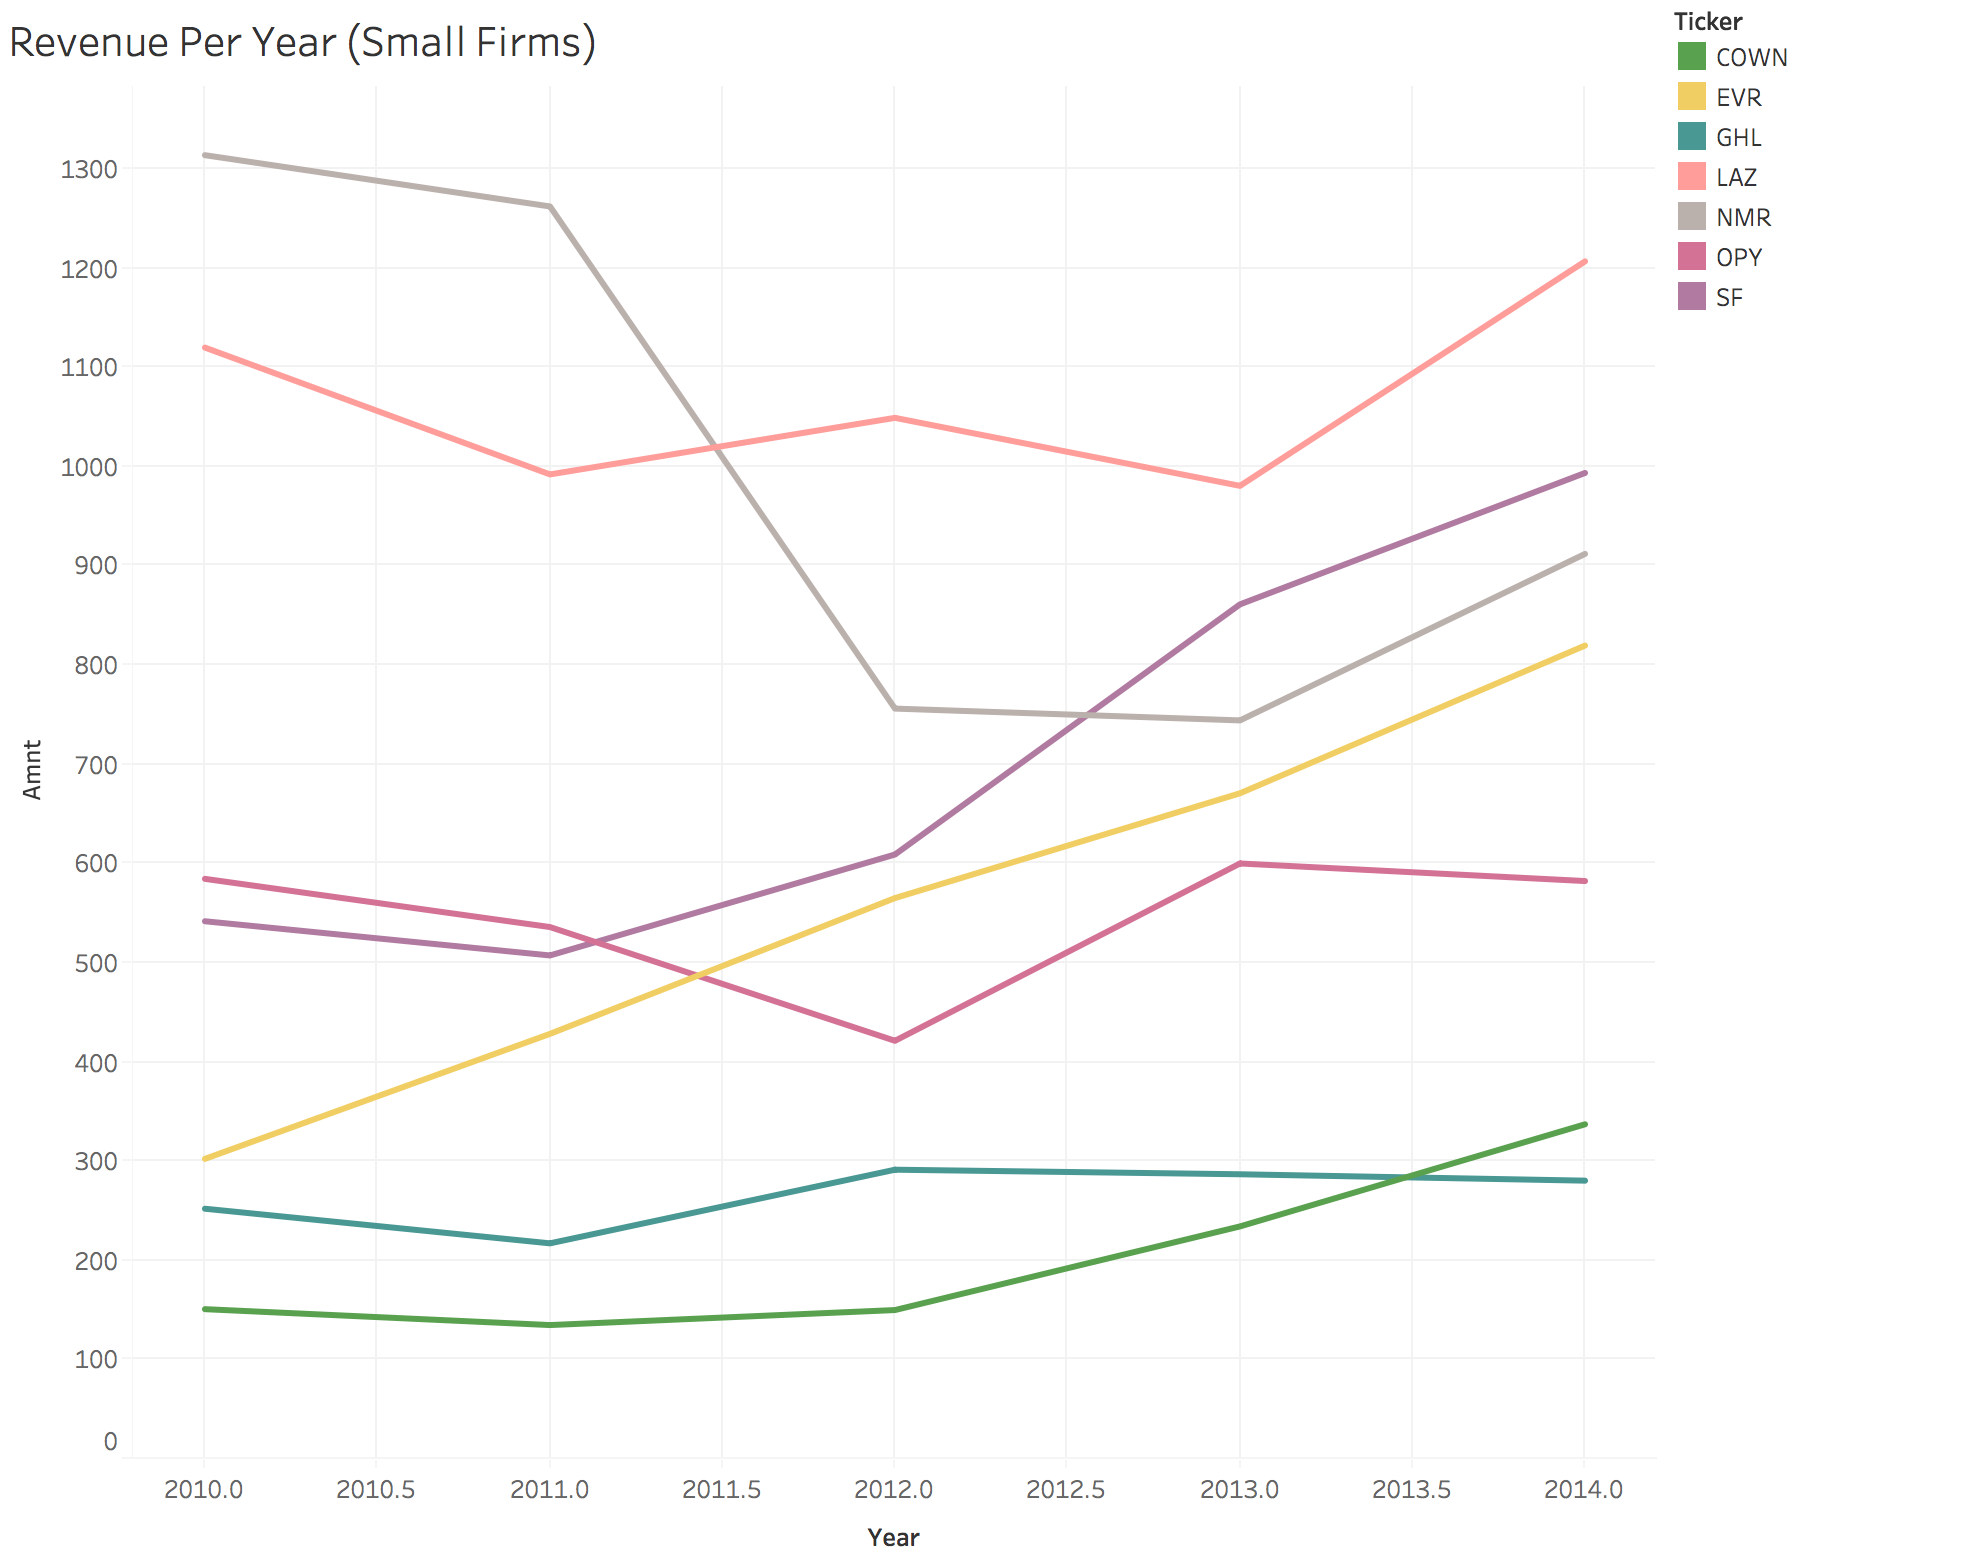

In [31]:
display(Image(filename='visualizations/revenue_per_year_small_firms.png'))

Stifle (SF) saw a large rise in revenue in 2012, which is most likely due to them merging with KBW that year

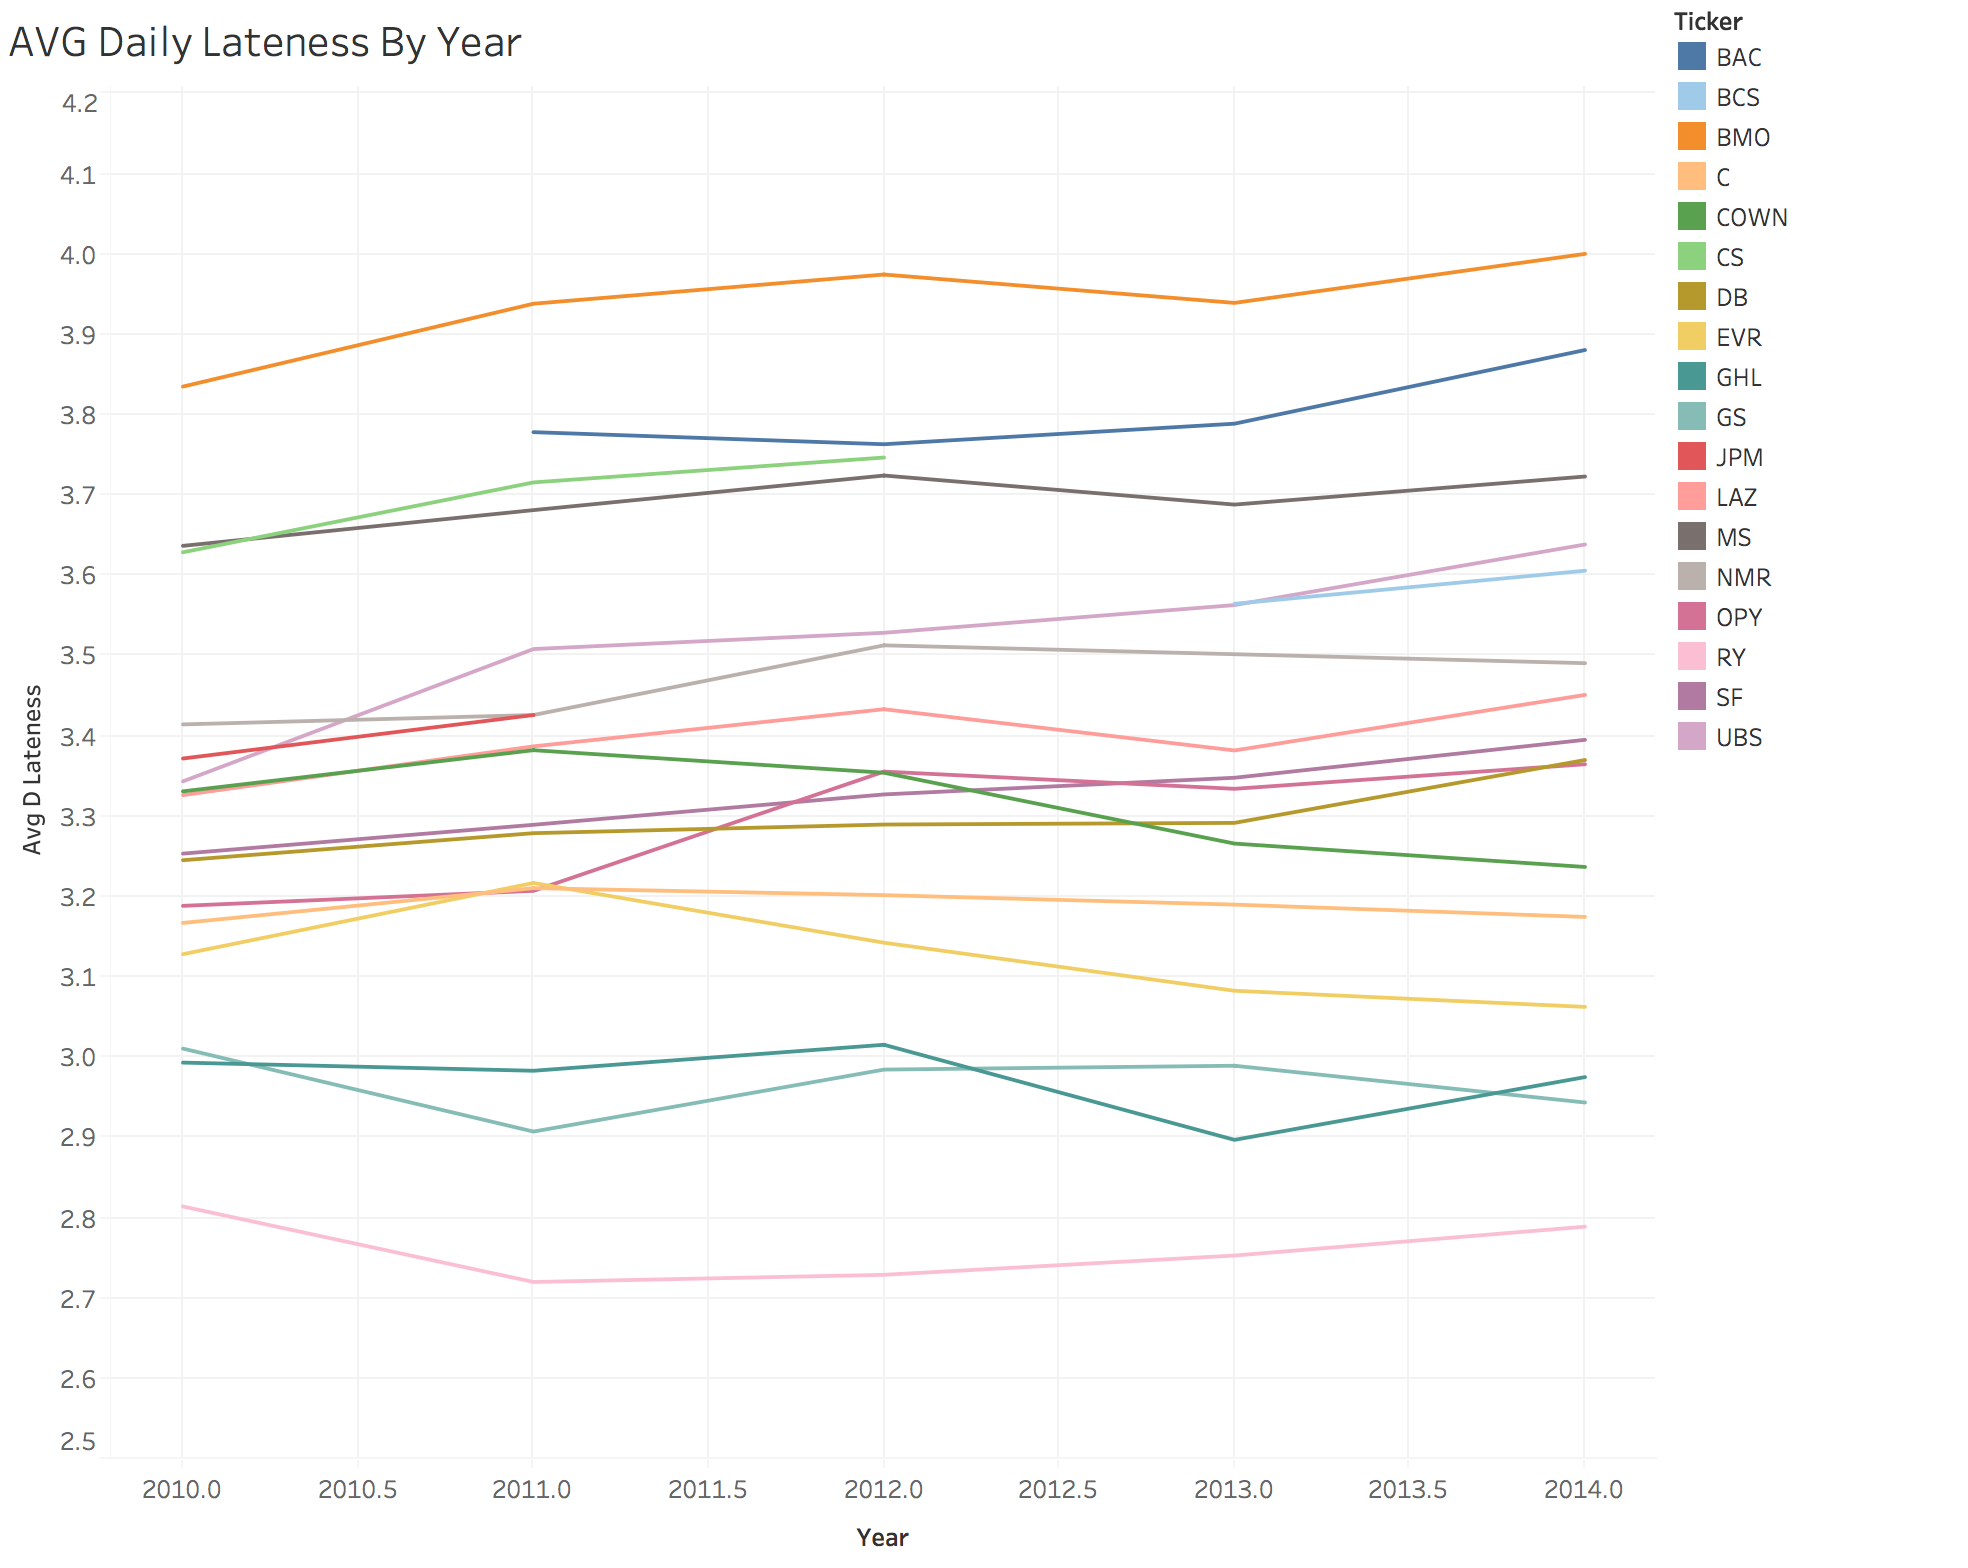

In [32]:
display(Image(filename='visualizations/avg_daily_lateness_per_year.png'))

Oppenheimer (OPY) saw a rise in average daily lateness in 2011, the same year they moved locations to a lower part of Manhattan.

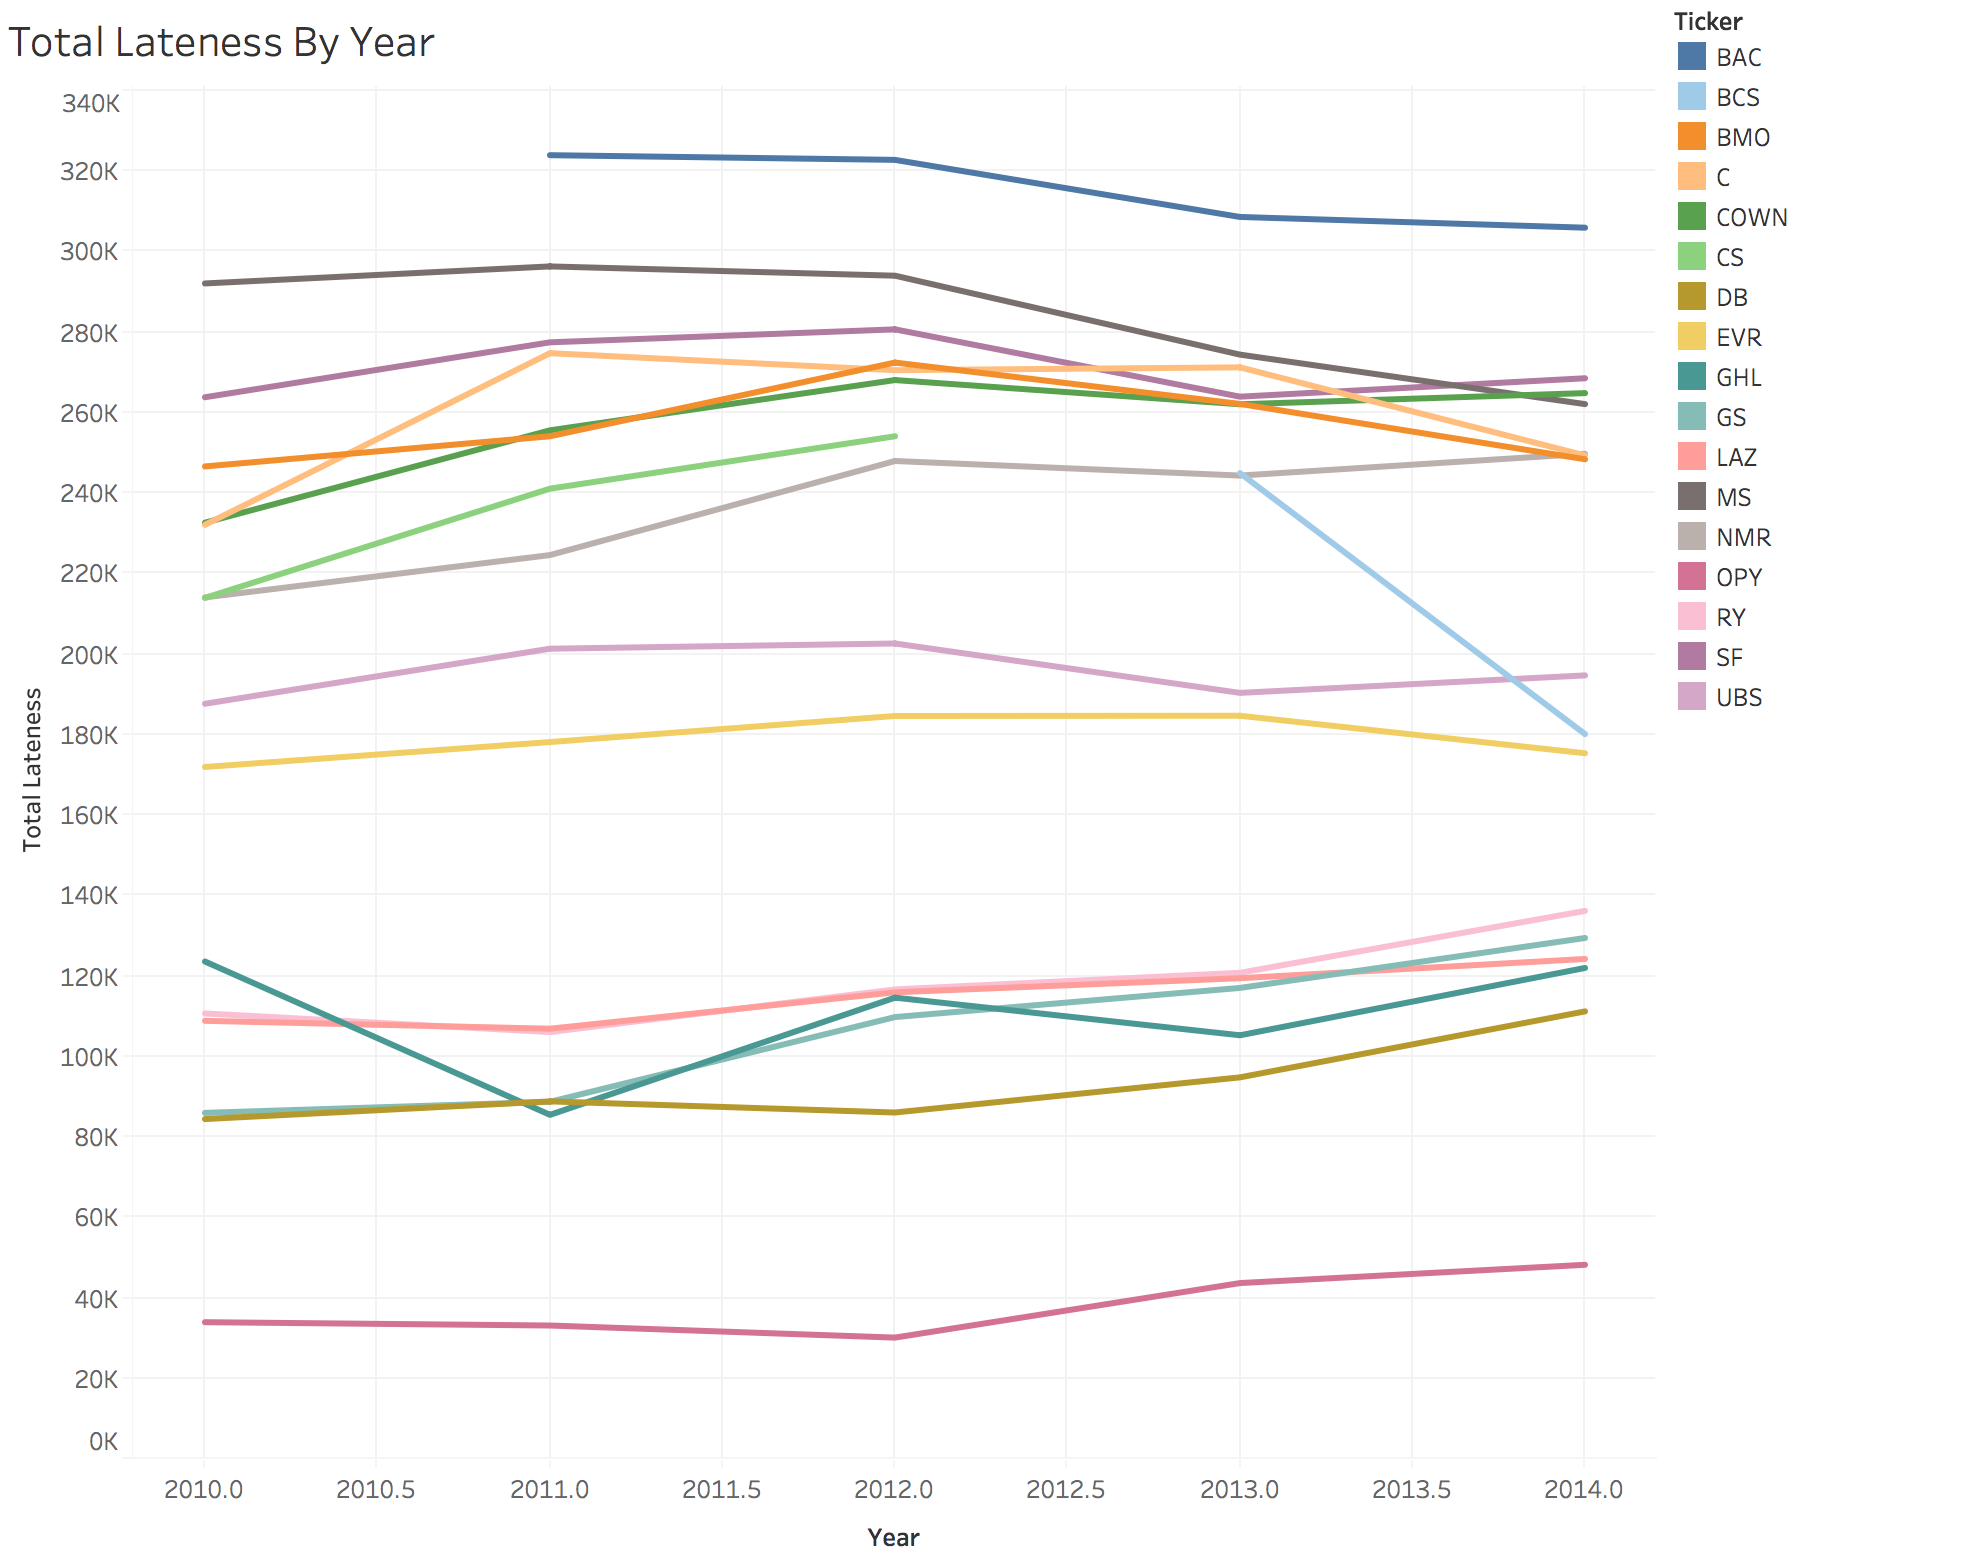

In [33]:
display(Image(filename='visualizations/total_lateness_per_year.png'))

Bank of America (BAC) has seen a decrease in total late hours spent but an increase in average daily lateness since 2012. In 2013, a BAC intern died of conditions most likely sustained from lack of sleep and overwork. As a result, the firm began discouraging employees from working between 12am and 7am. We hypothesize that this was due to consistently later hours worked rather than sporadic late nights.


Finally, check out this cool map of all of our rides, illustrating where our firms are

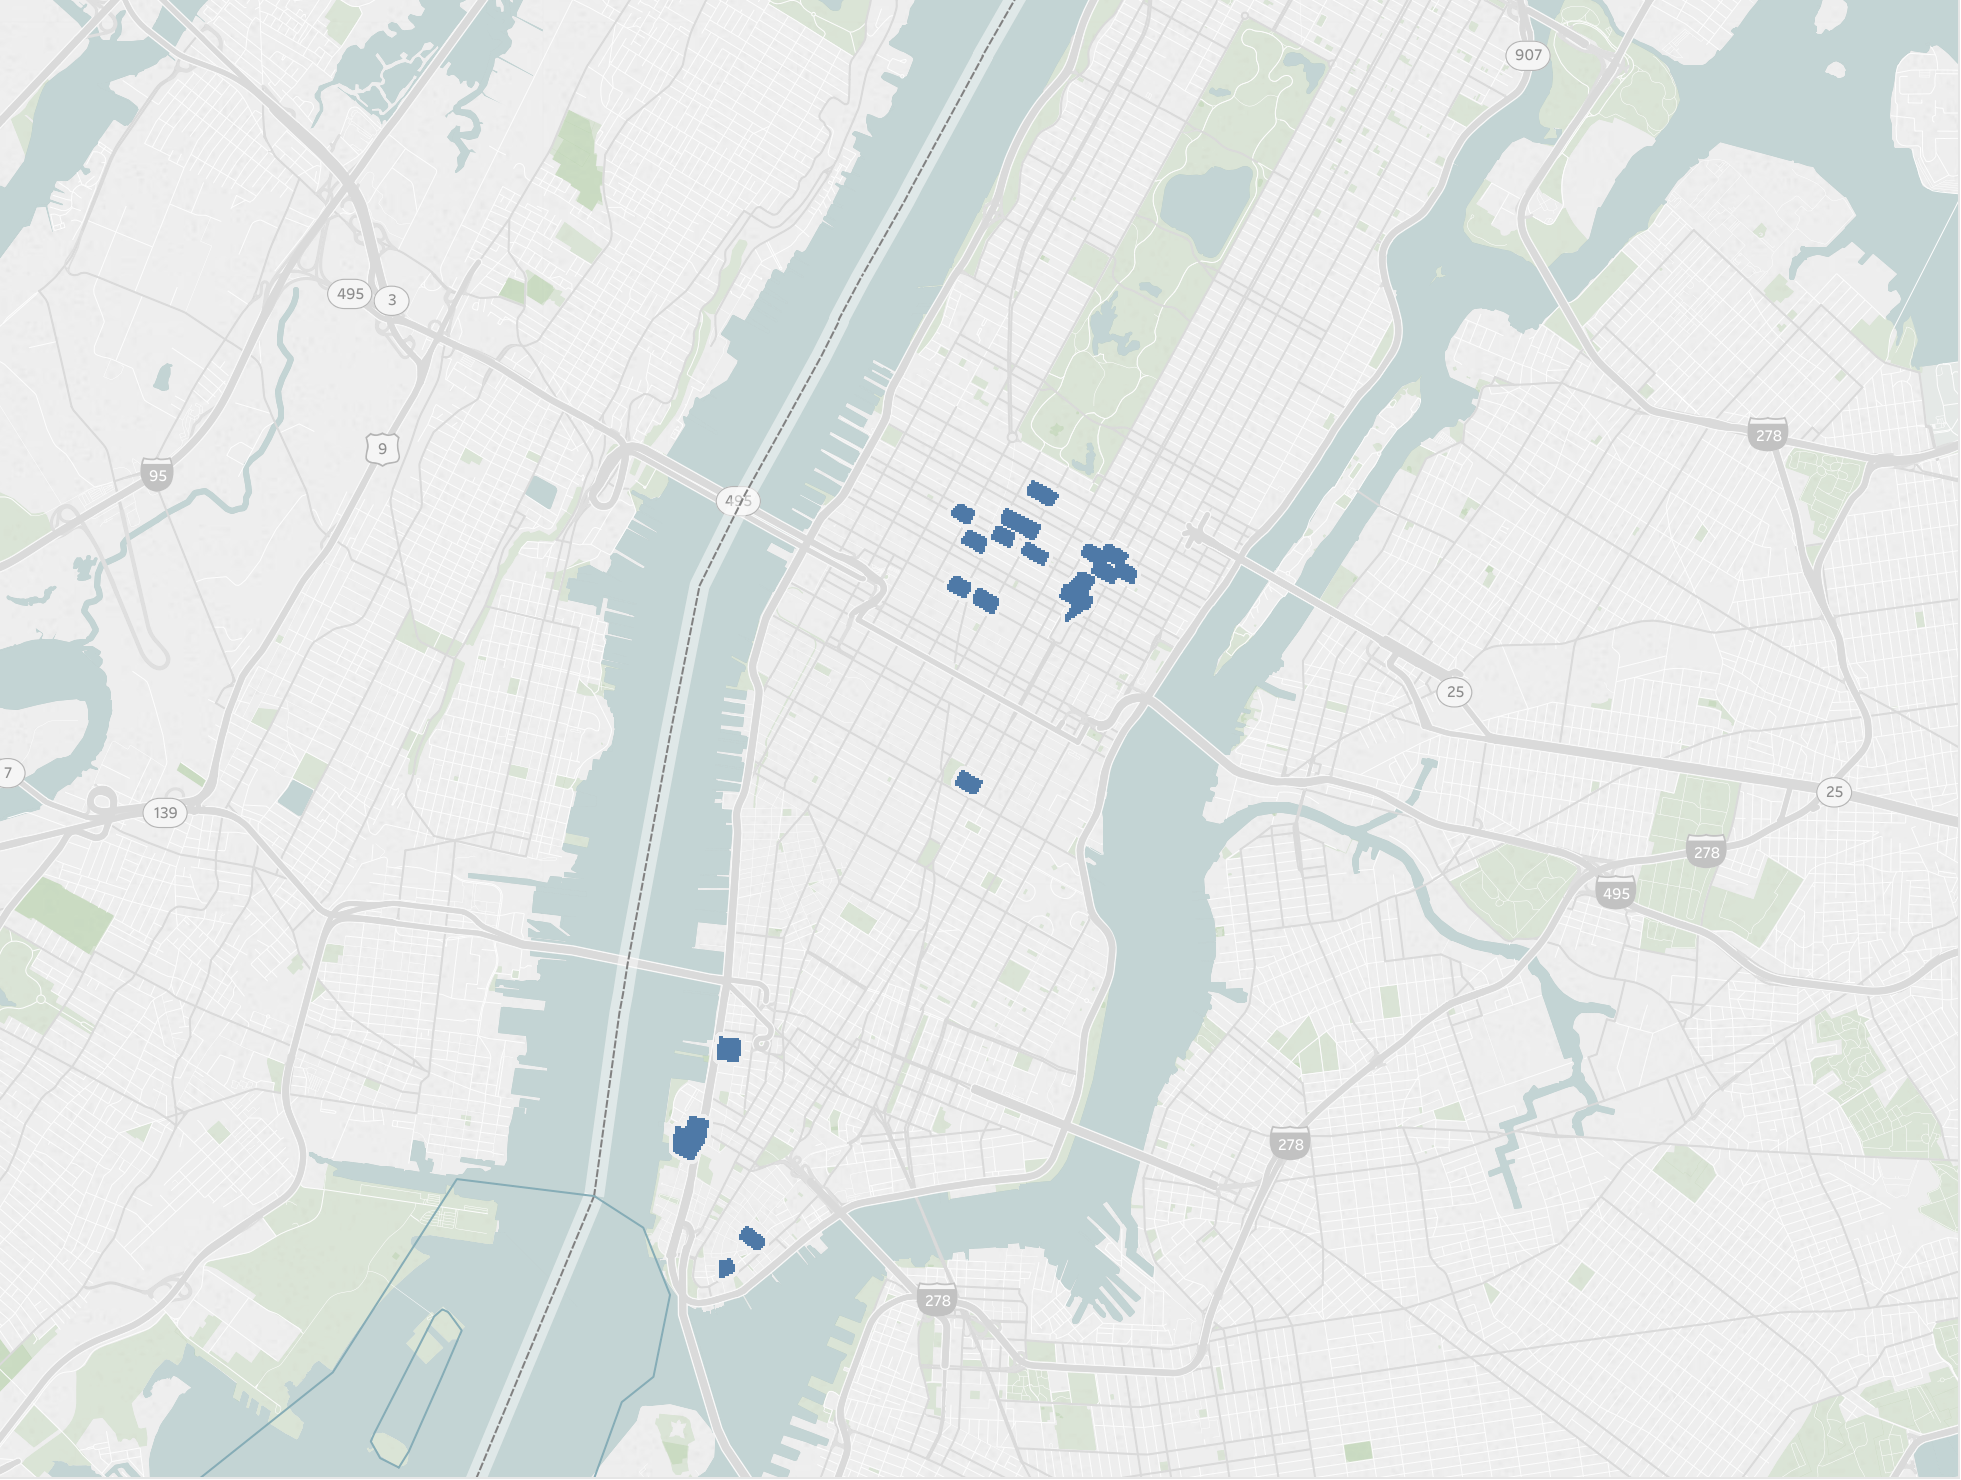

In [34]:
display(Image(filename='visualizations/map.png'))

# In Conclusion

Overall, we found some interesting characteristics in our data through exploration and found that our hypothesis was not substantiated on the majority of firms, but does show some level of significance for certain firms with particular time lags. This, though unlikely, could be due to random chance, and may not be indicative of some sort of causal or correlational relationship. For further testing of this model, one should implement more advanced hypothesis testing such as F-tests and T-tests and produce P-values. For future extension, one might analyze quarterly lateness as a percentage of the moving average of said quarterly lateness and then regress that metric against quarterly earnings as a percentage of quarterly earnings estimates. Furthermore, one could regress this against stock price movements. Given that predicting investment banking revenue alone does not lead to a clear trading decision, such a model factoring in stock trading patterns would allow for better adoption into algorithmic trading platforms that would likely produce outsized returns given any level of risk.